In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

# load EIT

In [4]:
darkImgData =np.loadtxt("./EIT/darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

results = np.genfromtxt("./EIT/EITresults/EIT_LC_withflags.txt")
print(np.shape(results))

(2467, 3)
(91883, 7)


In [45]:
metadata = Table.read("./EIT/EITresults/EIT_headerMetadata.txt",format="ascii")
print(metadata.colnames)

['DATE-BEG', 'DATE-AVG', 'XPOSURE', 'CMDXPOS', 'SHUTCLS', 'FILTER', 'WAVELNTH', 'OBJECT', 'SCI_OBJ', 'OBS_PROG', 'CMP_NO', 'UCD', 'EXPMODE', 'LYNESYNC', 'ROUTPORT', 'NLEBPROC', 'LEBPROC1', 'LEBPROC2', 'LEBPROC3', 'WCSNAME', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CROTA', 'CFTEMP', 'CCDTEMP', 'SOLAR_B0', 'RSUN_ARC', 'RSUN_OBS', 'RSUN_REF', 'CAR_ROT', 'DSUN_OBS', 'SC_X0', 'SC_Y0', 'SC_ROLL', 'HAEX_OBS', 'HAEY_OBS', 'HAEZ_OBS']


In [5]:
ts = results[:,0]                               # average date of observation
dists = results[:,1]                            # heliocentric distance in meters
ws = results[:,2].astype(float)                 # wavelength of observation
fs = results[:,3] * (dists/np.median(dists))    # normalize flux by heliocentric distance
us = results[:,4] * (dists/np.median(dists))    # normalize flux uncertainty by heliocentric distance
ps = results[:,5]                               # pinhole flag (==1 if Yes; can only ==1 if the Al_+1 filter was not used)
ces = results[:,6]                              # cameraError flag (==1 if Yes; still not clear exactly what this means)

m171 = (ws == 171.) 
m195 = (ws == 195.) 
m284 = (ws == 284.) 
m304 = (ws == 304.) 
wmasks = [m304,m284,m195,m171]

noPinholes = (ps == 0)
noCameraErrors = (ces == 0)


In [6]:
print("171")
print(np.shape(fs[m171]))
print(np.shape(fs[m171 & noPinholes])[0]/np.shape(fs[m171])[0])
print(np.shape(fs[m171 & noPinholes & noCameraErrors])[0]/np.shape(fs[m171])[0])

print("195")
print(np.shape(fs[m195]))
print(np.shape(fs[m195 & noPinholes])[0]/np.shape(fs[m195])[0])
print(np.shape(fs[m195 & noPinholes & noCameraErrors])[0]/np.shape(fs[m195])[0])

print("284")
print(np.shape(fs[m284]))
print(np.shape(fs[m284 & noPinholes])[0]/np.shape(fs[m284])[0])
print(np.shape(fs[m284 & noPinholes & noCameraErrors])[0]/np.shape(fs[m284])[0])

print("304")
print(np.shape(fs[m304]))
print(np.shape(fs[m304 & noPinholes])[0]/np.shape(fs[m304])[0])
print(np.shape(fs[m304 & noPinholes & noCameraErrors])[0]/np.shape(fs[m304])[0])

171
(22735,)
0.9996481196393227
0.5035847811744008
195
(23507,)
0.9953630833368784
0.5048283490024248
284
(22845,)
0.9440140074414533
0.4671481724666229
304
(22796,)
0.9955693981400245
0.49328829619231446


In [60]:
bakeoutDates = Table.read("./EIT/EITbakeoutDates.txt", format="ascii.basic")
bakeoutDates['jd'] = 0.

for i in range(len(bakeoutDates)):
    date = str(bakeoutDates['date_beg'][i])
    time = str(bakeoutDates['time_beg'][i]).zfill(5)

    y = int(date.split("/")[0])
    m = int(date.split("/")[1])
    d = int(date.split("/")[2])

    h = int(time.split(":")[0])
    min = int(time.split(":")[1])
    
    bakeoutDates[i]['jd'] = np.round(astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':h, 'minute':min}).jd,3)
    

heaterOnMask = (bakeoutDates['status'] == 'heaterOn')
heaterOffMask = (bakeoutDates['status'] == 'heaterOff')

heaterOn = bakeoutDates[heaterOnMask]
heaterOff = bakeoutDates[heaterOffMask]
print(heaterOn[50:])
print(heaterOff[50:])

 status   date_beg  time_beg dur[h]      jd    
-------- ---------- -------- ------ -----------
heaterOn 2007/05/18    18:00  141.0  2454239.25
heaterOn 2007/08/26    21:00  132.0 2454339.375
heaterOn 2007/11/19    11:00  120.0 2454423.958
heaterOn 2008/02/22    21:00  145.0 2454519.375
heaterOn 2008/05/16    22:44  136.0 2454603.447
heaterOn  2008/08/8    16:30  278.5 2454687.188
heaterOn 2008/11/12    11:30  163.5 2454782.979
heaterOn  2009/02/7    20:15  168.0 2454870.344
heaterOn  2009/05/2    17:00  132.0 2454954.208
heaterOn  2009/08/4    18:00  176.0  2455048.25
heaterOn 2009/11/01    16:00  119.0 2455137.167
heaterOn 2010/01/27    20:00  131.0 2455224.333
heaterOn 2010/04/26    01:00  129.0 2455312.542
heaterOn 2010/07/20    23:30  175.5 2455398.479
heaterOn  2011/02/9    17:00  161.0 2455602.208
heaterOn 2011/07/18    15:30  102.5 2455761.146
heaterOn  2012/01/5    21:00  145.0 2455932.375
heaterOn  2012/07/2    14:30  153.5 2456111.104
heaterOn 2013/06/21    10:20  230.0 2456

# load SEM

In [8]:
# normalized by heliocentric distance
SEM = Table.read("./CELIAS-SEM/SEMDailyData_norm.txt",format="ascii")
print(SEM.colnames)

['t_obs[JD]', 'firstOrderFlux[counts/s]', 'firstOrderFluxUnc[counts/s]', 'centralOrderFlux[counts/s]', 'centralOrderFluxUnc[counts/s]']


# load SORCE

In [68]:
# from header:
# "Irradiances are reported at a mean solar distance of 1 AU and zero
#; relative line-of-sight velocity with respect to the Sun."
# so already normalized by heliocentric distance.
SORCE = Table.read("./SORCE/SORCEfluxTransmittedThroughEITFilters.txt", format="ascii")
print(SORCE.colnames)
print(SORCE['date[JD]'][0])
print(SORCE['date[JD]'][-1])

['date[JD]', 'transmitted_flux_171[arb.units]', 'transmitted_flux_195[arb.units]', 'transmitted_flux_284[arb.units]', 'transmitted_flux_304[arb.units]', 'transmitted_flux_sumEITBands[arb.units]']
2452696.0
2458904.0


# load VIRGO

In [10]:
VIRGO = Table.read("./VIRGO/virgoDailyData.txt",format="ascii")
print(VIRGO)

t_obs[JD] flux[W/m^2] flux_unc[W/m^2]
--------- ----------- ---------------
2450135.0    1360.481           0.131
2450136.0    1360.406           0.131
2450137.0    1360.412           0.136
2450138.0    1360.411           0.131
2450139.0    1360.444           0.136
2450140.0    1360.466           0.131
2450141.0    1360.456           0.135
2450142.0    1360.423           0.133
2450143.0    1360.401           0.133
2450144.0    1360.383           0.135
2450145.0    1360.365           0.131
2450146.0    1360.373           0.137
2450147.0    1360.371           0.131
2450148.0    1360.401           0.136
      ...         ...             ...
2460250.0    1362.126           0.141
2460251.0    1362.337           0.147
2460252.0    1362.256           0.148
2460253.0    1362.128           0.141
2460254.0    1361.907           0.144
2460255.0    1361.639           0.144
2460256.0    1361.522           0.147
2460257.0    1361.627           0.168
2460258.0    1361.731           0.179
2460259.0   

# Arrays to plot

In [11]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
labels =['304','284','195','171']

wmask_304 = wmasks[0] & noPinholes
t304 = ts[wmask_304]
f304 = fs[wmask_304]
u304 = us[wmask_304]

wmask_284 = wmasks[1] & noPinholes
t284 = ts[wmask_284]
f284 = fs[wmask_284]
u284 = us[wmask_284]

wmask_195 = wmasks[2] & noPinholes
t195 = ts[wmask_195]
f195 = fs[wmask_195]
u195 = us[wmask_195]

wmask_171 = wmasks[3] & noPinholes
t171 = ts[wmask_171]
f171 = fs[wmask_171]
u171 = us[wmask_171]

tSEM = np.array(SEM['t_obs[JD]'])
fSEM = np.array(SEM['firstOrderFlux[counts/s]'])
uSEM = np.array(SEM['firstOrderFluxUnc[counts/s]'])

tSORCE = np.array(SORCE['date[JD]'])
fSORCE = np.array(SORCE['transmitted_flux_sumEITBands[arb.units]'])
# haven't propagated the uncertainties here yet, but can later if useful

tVIRGO = np.array(VIRGO['t_obs[JD]'])
fVIRGO = np.array(VIRGO['flux[W/m^2]'])
uVIRGO = np.array(VIRGO['flux_unc[W/m^2]'])

# Plots

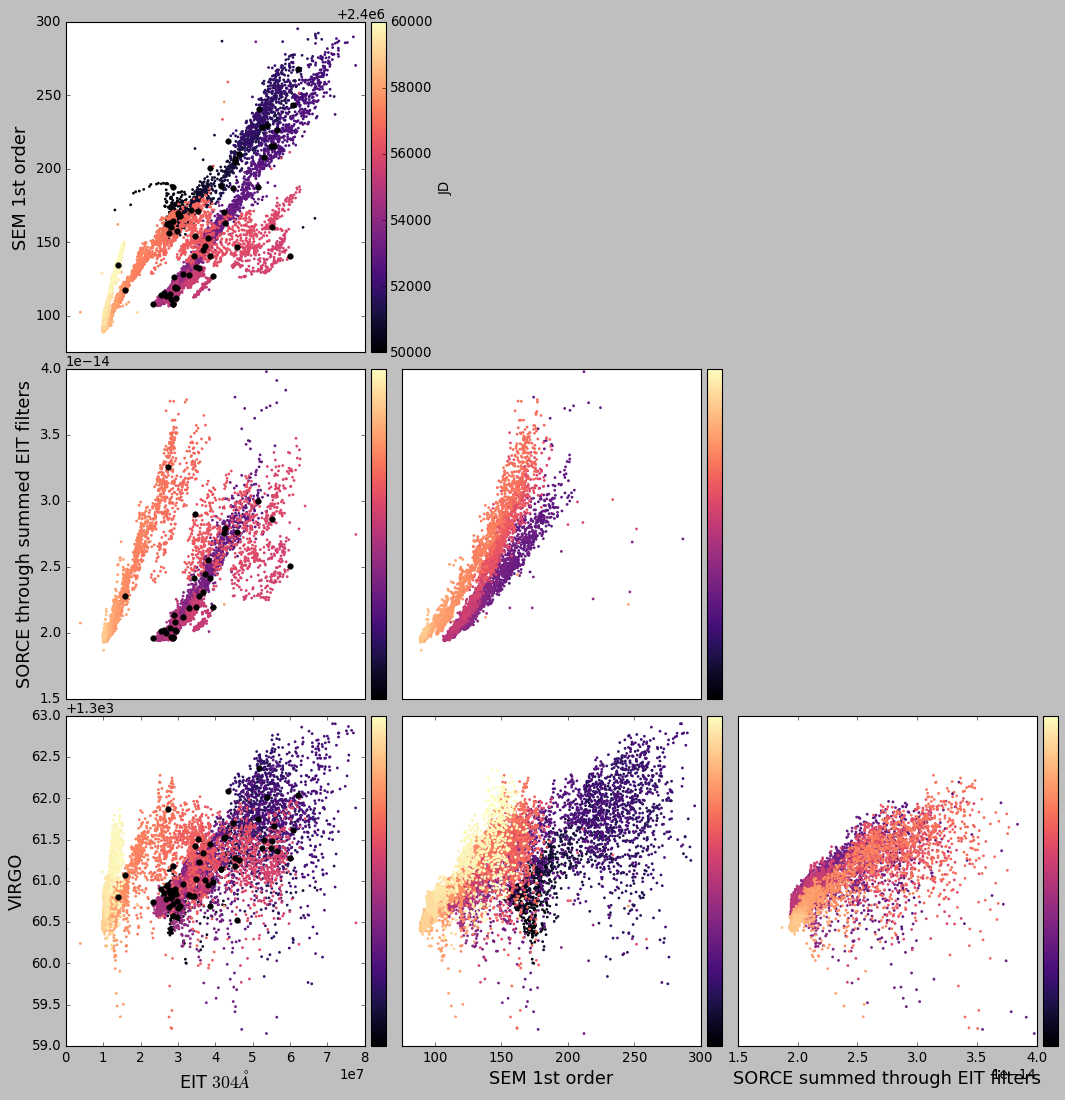

In [63]:
fig, axes = plt.subplots(3,3,figsize=(16,16))

#axes[0,0]: SEM 1st order vs EIT 304\AA
overlap_t, t304_ind, tSEM_ind = np.intersect1d(np.round(t304,0), np.round(tSEM,0), return_indices=True)
bk_overlap_t, bk_bk_ind, bk_t304_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(t304[t304_ind],0), return_indices=True)
bk_overlap_t, bk_bk_ind, bk_tSEM_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(tSEM[tSEM_ind],0), return_indices=True)

cs00 = axes[0,0].scatter(f304[t304_ind], fSEM[tSEM_ind], c=t304[t304_ind],marker='.', s=25, edgecolor='None', cmap='magma',vmin=2450000,vmax=2460000)
axes[0,0].plot(f304[t304_ind][bk_t304_ind], fSEM[tSEM_ind][bk_tSEM_ind],ls='None', marker='.',ms=10,color='k')

divider = make_axes_locatable(axes[0,0])
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
fig.colorbar(cs00, cax=cax,label="JD")

#axes[0,0].set_xlabel(r"EIT $304\AA$")
axes[0,0].set_ylabel(r"SEM 1st order",fontsize=16)
axes[0,0].set_xlim(0.,8.e7)
axes[0,0].set_ylim(75.,300)


#axes[1,0]: SORCE "total" UV LC vs EIT 304\AA
overlap_t, t304_ind, tSORCE_ind = np.intersect1d(np.round(t304,0), np.round(tSORCE,0), return_indices=True)
bk_overlap_t, bk_bk_ind, bk_t304_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(t304[t304_ind],0), return_indices=True)
bk_overlap_t, bk_bk_ind, bk_tSORCE_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(tSORCE[tSORCE_ind],0), return_indices=True)

cs10 = axes[1,0].scatter(f304[t304_ind], fSORCE[tSORCE_ind], c=t304[t304_ind],marker='.', s=25, edgecolor='None', cmap='magma',vmin=2450000,vmax=2460000)
axes[1,0].plot(f304[t304_ind][bk_t304_ind], fSORCE[tSORCE_ind][bk_tSORCE_ind], ls='None', marker='.',ms=10,color='k')

divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
cbar = fig.colorbar(cs10, cax=cax)#,label="JD")
cbar.set_ticks([])

#axes[1,0].set_xlabel(r"EIT $304\AA$")
axes[1,0].set_ylabel(r"SORCE through summed EIT filters",fontsize=16)
axes[1,0].set_xlim(0.,8.e7)
axes[1,0].set_ylim(1.5e-14,4.0e-14)


#axes[2,0]: VIRGO vs EIT 304\AA
overlap_t, t304_ind, tVIRGO_ind = np.intersect1d(np.round(t304,0), np.round(tVIRGO,0), return_indices=True)
bk_overlap_t, bk_bk_ind, bk_t304_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(t304[t304_ind],0), return_indices=True)
bk_overlap_t, bk_bk_ind, bk_tVIRGO_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(tVIRGO[tVIRGO_ind],0), return_indices=True)

cs20 = axes[2,0].scatter(f304[t304_ind], fVIRGO[tVIRGO_ind], c=t304[t304_ind],marker='.', s=25, edgecolor='None', cmap='magma',vmin=2450000,vmax=2460000)
axes[2,0].plot(f304[t304_ind][bk_t304_ind], fVIRGO[tVIRGO_ind][bk_tVIRGO_ind], ls='None', marker='.',ms=10,color='k')

divider = make_axes_locatable(axes[2,0])
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
cbar = fig.colorbar(cs20, cax=cax)#,label="JD")
cbar.set_ticks([])

axes[2,0].set_xlabel(r"EIT $304\AA$",fontsize=16)
axes[2,0].set_ylabel(r"VIRGO",fontsize=16)
axes[2,0].set_xlim(0.,8.e7)
axes[2,0].set_ylim(1359,1363)


#axes[1,1]: SORCE "total" UV LC vs SEM 1st order
overlap_t, tSEM_ind, tSORCE_ind = np.intersect1d(np.round(tSEM,0), np.round(tSORCE,0), return_indices=True)

cs11 = axes[1,1].scatter(fSEM[tSEM_ind], fSORCE[tSORCE_ind], c=tSEM[tSEM_ind],marker='.', s=25, edgecolor='None', cmap='magma',vmin=2450000,vmax=2460000)

divider = make_axes_locatable(axes[1,1])
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
cbar = fig.colorbar(cs11, cax=cax)#,label="JD")
cbar.set_ticks([])

#axes[1,1].set_xlabel(r"SEM 1st order")
#axes[1,1].set_ylabel(r"SORCE through summed EIT filters")
axes[1,1].set_xlim(75.,300)
axes[1,1].set_ylim(1.5e-14,4.0e-14)

#axes[2,1]: VIRGO vs SEM 1st order
overlap_t, tSEM_ind, tVIRGO_ind = np.intersect1d(np.round(tSEM,0), np.round(tVIRGO,0), return_indices=True)

cs21 = axes[2,1].scatter(fSEM[tSEM_ind], fVIRGO[tVIRGO_ind], c=tSEM[tSEM_ind],marker='.', s=25, edgecolor='None', cmap='magma',vmin=2450000,vmax=2460000)

divider = make_axes_locatable(axes[2,1])
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
cbar = fig.colorbar(cs21, cax=cax)#,label="JD")
cbar.set_ticks([])

axes[2,1].set_xlabel(r"SEM 1st order",fontsize=16)
#axes[2,1].set_ylabel(r"VIRGO")
axes[2,1].set_xlim(75.,300)
axes[2,1].set_ylim(1359,1363)

#axes[2,2]: VIRGO vs SORCE "total" UV LC
overlap_t, tSORCE_ind, tVIRGO_ind = np.intersect1d(np.round(tSORCE,0), np.round(tVIRGO,0), return_indices=True)

cs22 = axes[2,2].scatter(fSORCE[tSORCE_ind], fVIRGO[tVIRGO_ind], c=tSORCE[tSORCE_ind],marker='.', s=25, edgecolor='None', cmap='magma',vmin=2450000,vmax=2460000)

divider = make_axes_locatable(axes[2,2])
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
cbar = fig.colorbar(cs22, cax=cax)#,label="JD")
cbar.set_ticks([])

axes[2,2].set_xlabel(r"SORCE summed through EIT filters",fontsize=16)
#axes[2,2].set_ylabel(r"VIRGO")
axes[2,2].set_xlim(1.5e-14,4.0e-14)
axes[2,2].set_ylim(1359,1363)



for ax in [axes[0,1], axes[0,2], axes[1,2]]:
    ax.axis("off")

for ax in [axes[0,0], axes[1,0], axes[1,1]]:
    ax.set_xticks([])
for ax in [axes[1,1], axes[2,1], axes[2,2]]:
    ax.set_yticks([])

plt.subplots_adjust(hspace=0.05,wspace=0.05)

#plt.show()
plt.savefig("cornerPlot_EIT304_SEM1stOrder_SORCE_VIRGO.pdf",bbox_inches="tight")

## Ratio of EIT bands to SEM

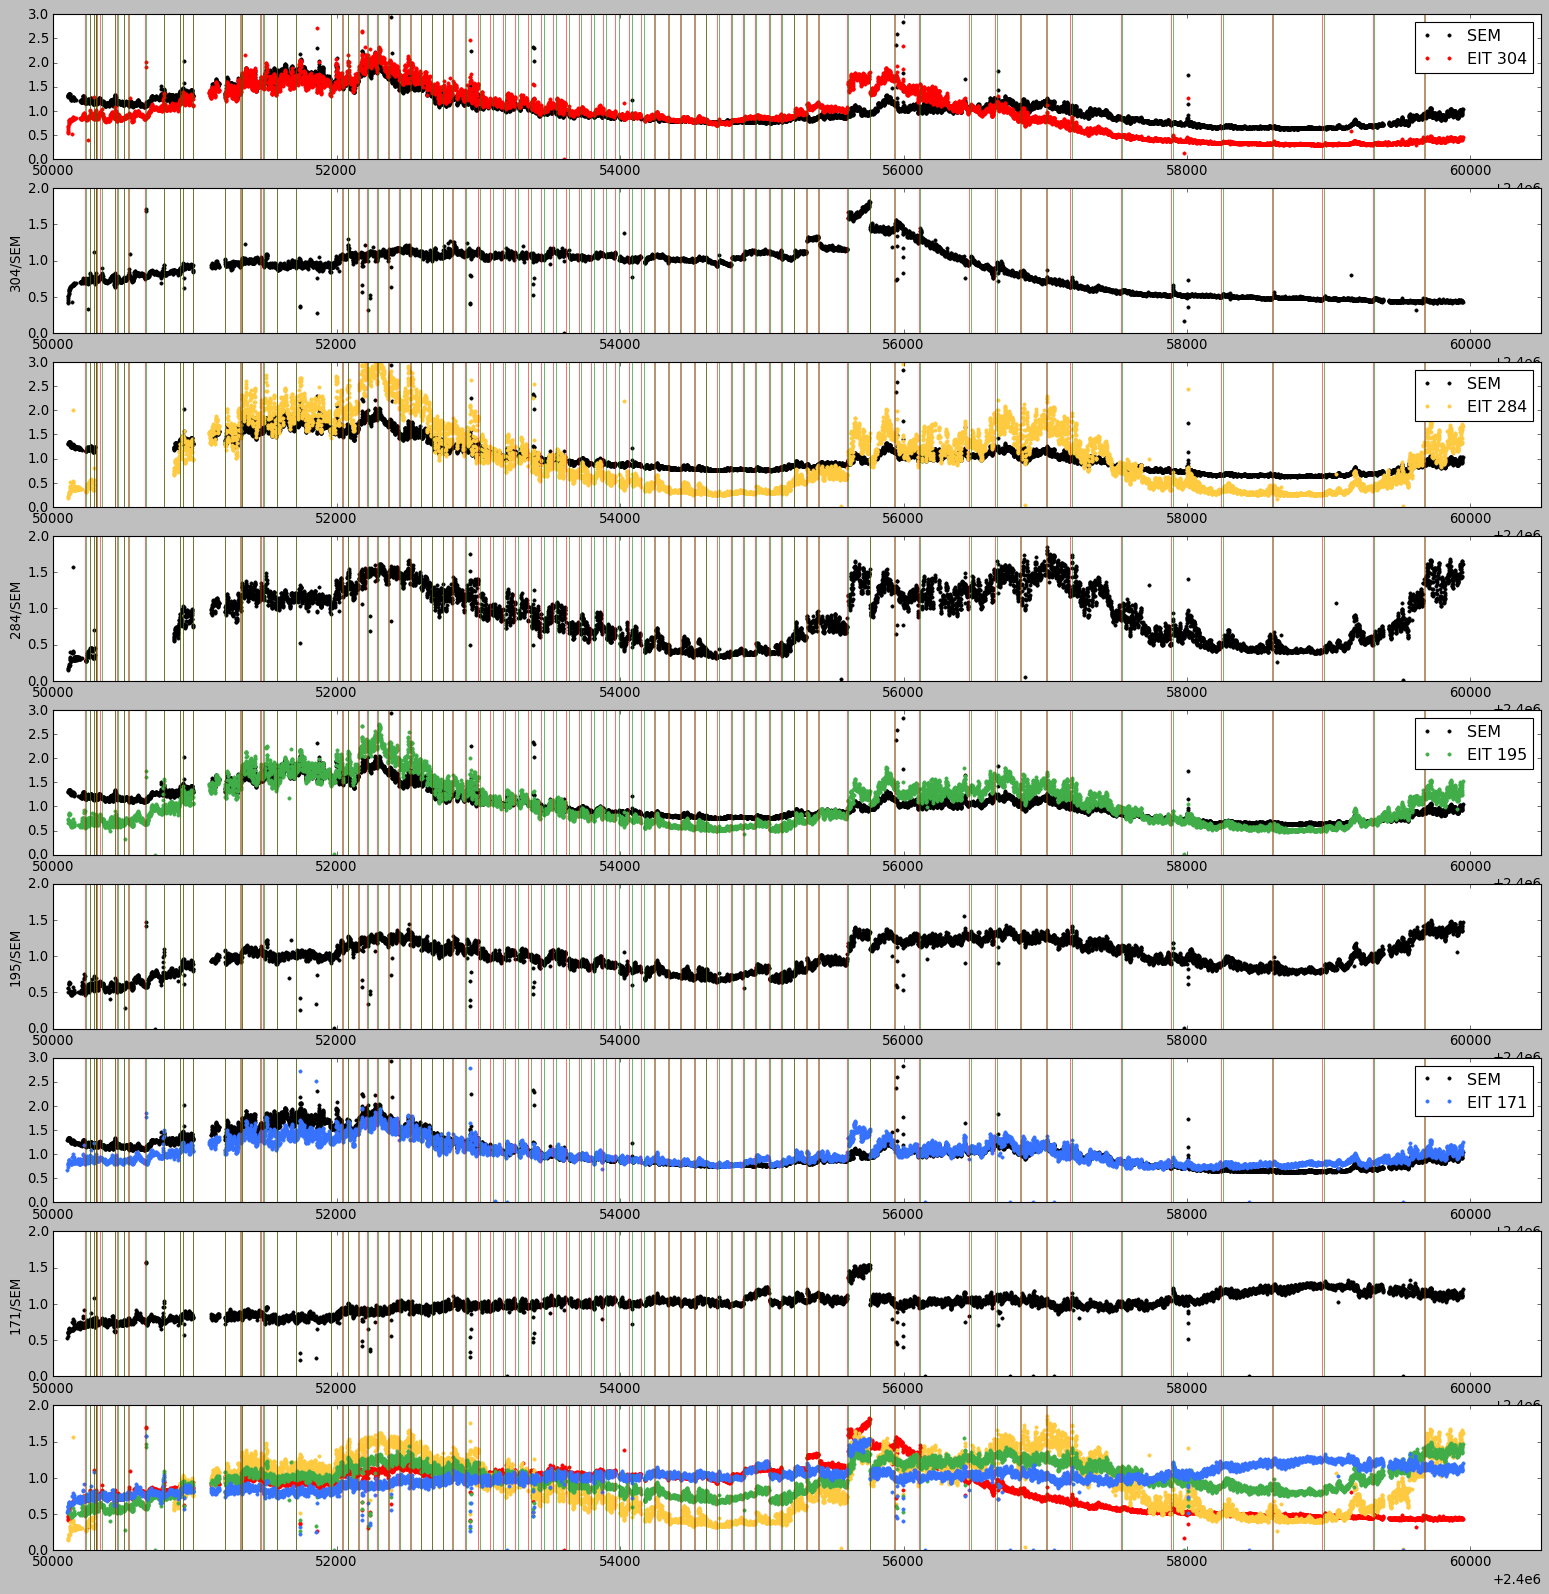

In [67]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, tSEM_ind = np.intersect1d(np.round(tEIT,0), np.round(tSEM,0), return_indices=True)
    axes[2*i].plot(tSEM[tSEM_ind], fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)]), 'k.',label='SEM')
    axes[2*i].plot(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]))
    axes[2*i].set_ylim(0.,3.)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)])),'k.')
    axes[2*i+1].set_ylim(0.,2.)
    axes[2*i+1].set_ylabel('{0}/SEM'.format(labels[i]))

    axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)])),marker='.',ls='None',color=cs[i])
    axes[8].set_ylim(0.,2.)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(80):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    # date of biggest problematic bakeout (11 Feb 2011)
    #ax.axvline(2455602.208, color='y', lw=3)
    #date of big SOHO pointing adjustment (22 Sept 2010)
    #ax.axvline(2455462.239114713, color='y', lw=3)

#plt.show()
plt.savefig("./ratio_EITbands_to_SEM1stOrder.pdf",bbox_inches="tight")

## Ratio of EIT bands to SORCE

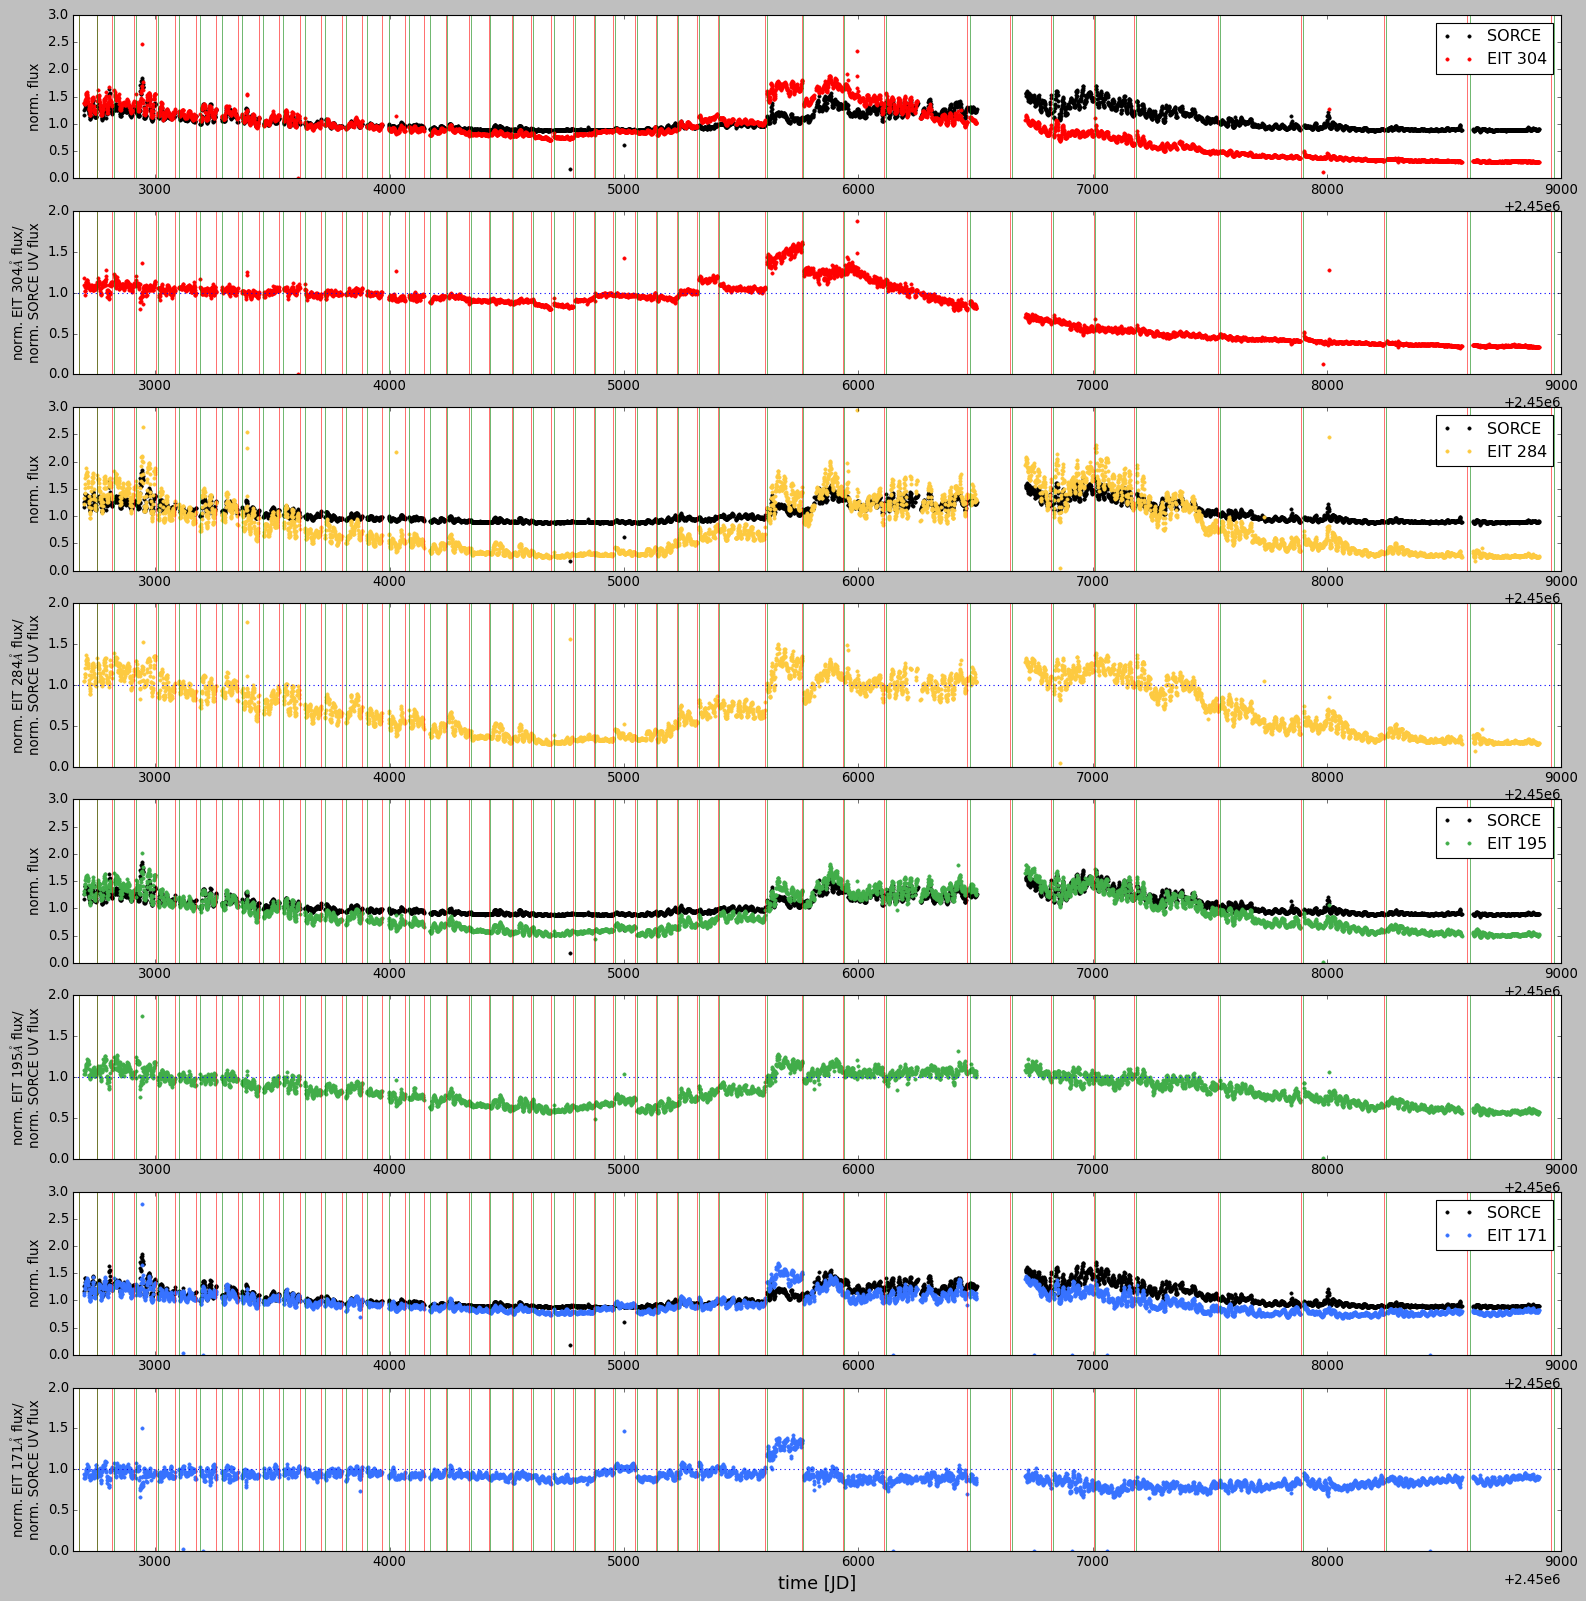

In [145]:
fig, axes = plt.subplots(8,1,figsize=(24,24))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, tSORCE_ind = np.intersect1d(np.round(tEIT,0), np.round(tSORCE,0), return_indices=True)
    axes[2*i].plot(tSORCE[tSORCE_ind], fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)]), 'k.',label='SORCE')
    axes[2*i].plot(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]))
    axes[2*i].set_ylim(0.,3.)
    axes[2*i].legend(loc='upper right')
    axes[2*i].set_ylabel('norm. flux')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)])),marker='.',color=cs[i],ls='None')
    axes[2*i+1].set_ylim(0.,2.)
    axes[2*i+1].set_ylabel(r'norm. EIT {0}$\AA$ flux/'.format(labels[i])+'\n'+'norm. SORCE UV flux')
    axes[2*i+1].axhline(1,ls=":")

    #axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)])),ls='None' ,marker='.',color=cs[i])
    #axes[8].set_ylim(0.,2.)
    

for ax in axes:
    ax.set_xlim(2452650,2459000)
    for i in range(80):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    #ax.axvline(2454832.5000000,color='y',lw=2)
axes[7].set_xlabel("time [JD]",fontsize=16)
#plt.show()
plt.savefig("./ratio_EITbands_to_SORCE.pdf",bbox_inches="tight")

## ratio of EIT bands to VIRGO

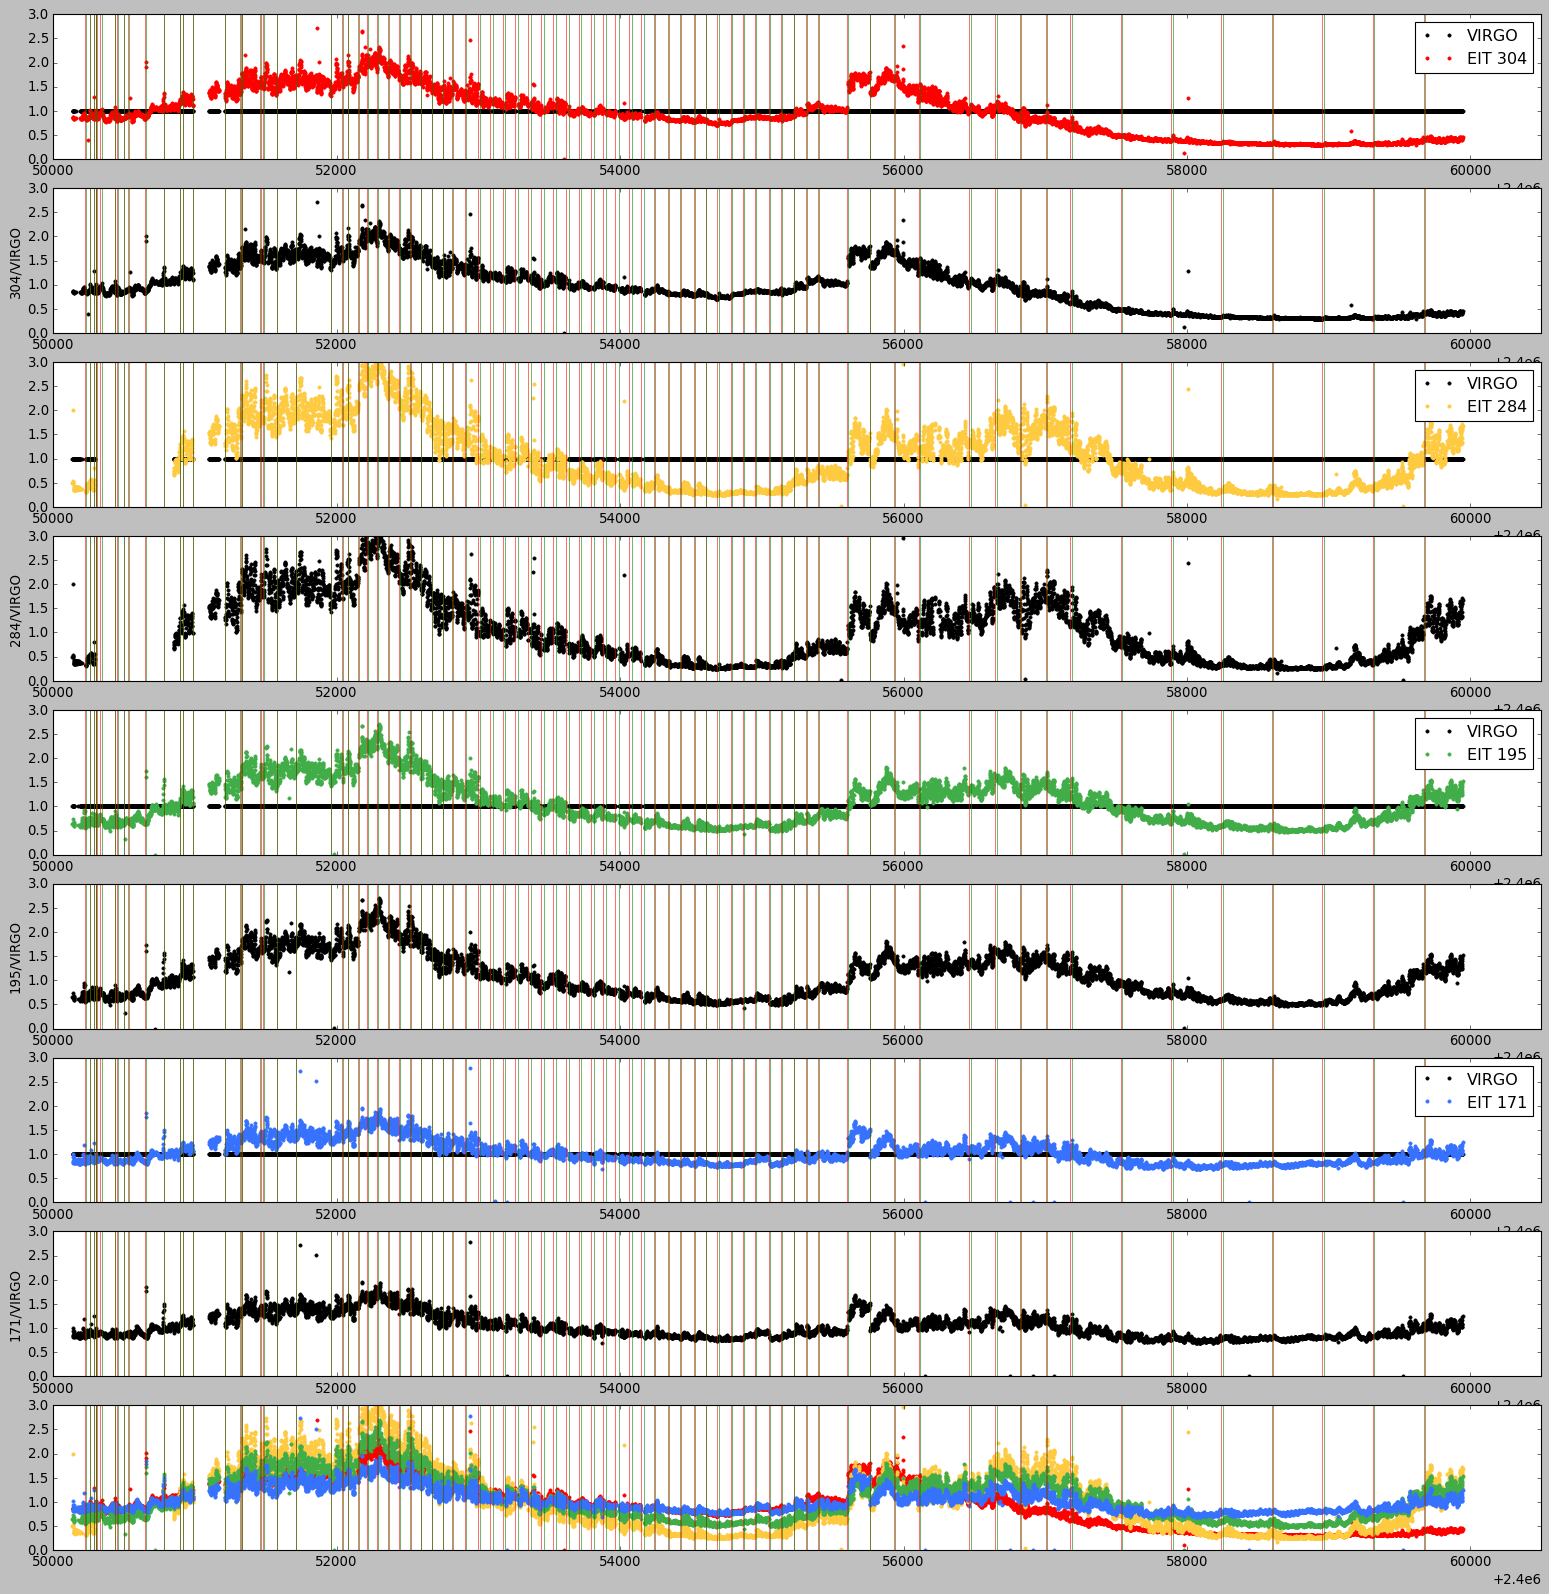

In [69]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, tVIRGO_ind = np.intersect1d(np.round(tEIT,0), np.round(tVIRGO,0), return_indices=True)
    axes[2*i].plot(tVIRGO[tVIRGO_ind], fVIRGO[tVIRGO_ind]/np.median(fVIRGO[~np.isnan(fVIRGO)]), 'k.',label='VIRGO')
    axes[2*i].plot(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]))
    axes[2*i].set_ylim(0.,3.)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fVIRGO[tVIRGO_ind]/np.median(fVIRGO[~np.isnan(fVIRGO)])),'k.')
    axes[2*i+1].set_ylim(0.,3.)
    axes[2*i+1].set_ylabel('{0}/VIRGO'.format(labels[i]))

    axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fVIRGO[tVIRGO_ind]/np.median(fVIRGO[~np.isnan(fVIRGO)])),ls='None' ,marker='.',color=cs[i])
    axes[8].set_ylim(0.,3.)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(80):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)

#plt.show()
plt.savefig("./ratio_EITbands_to_VIRGO.pdf",bbox_inches="tight")

# Ratio of EIT bands to each other (have somehow never looked at this?)

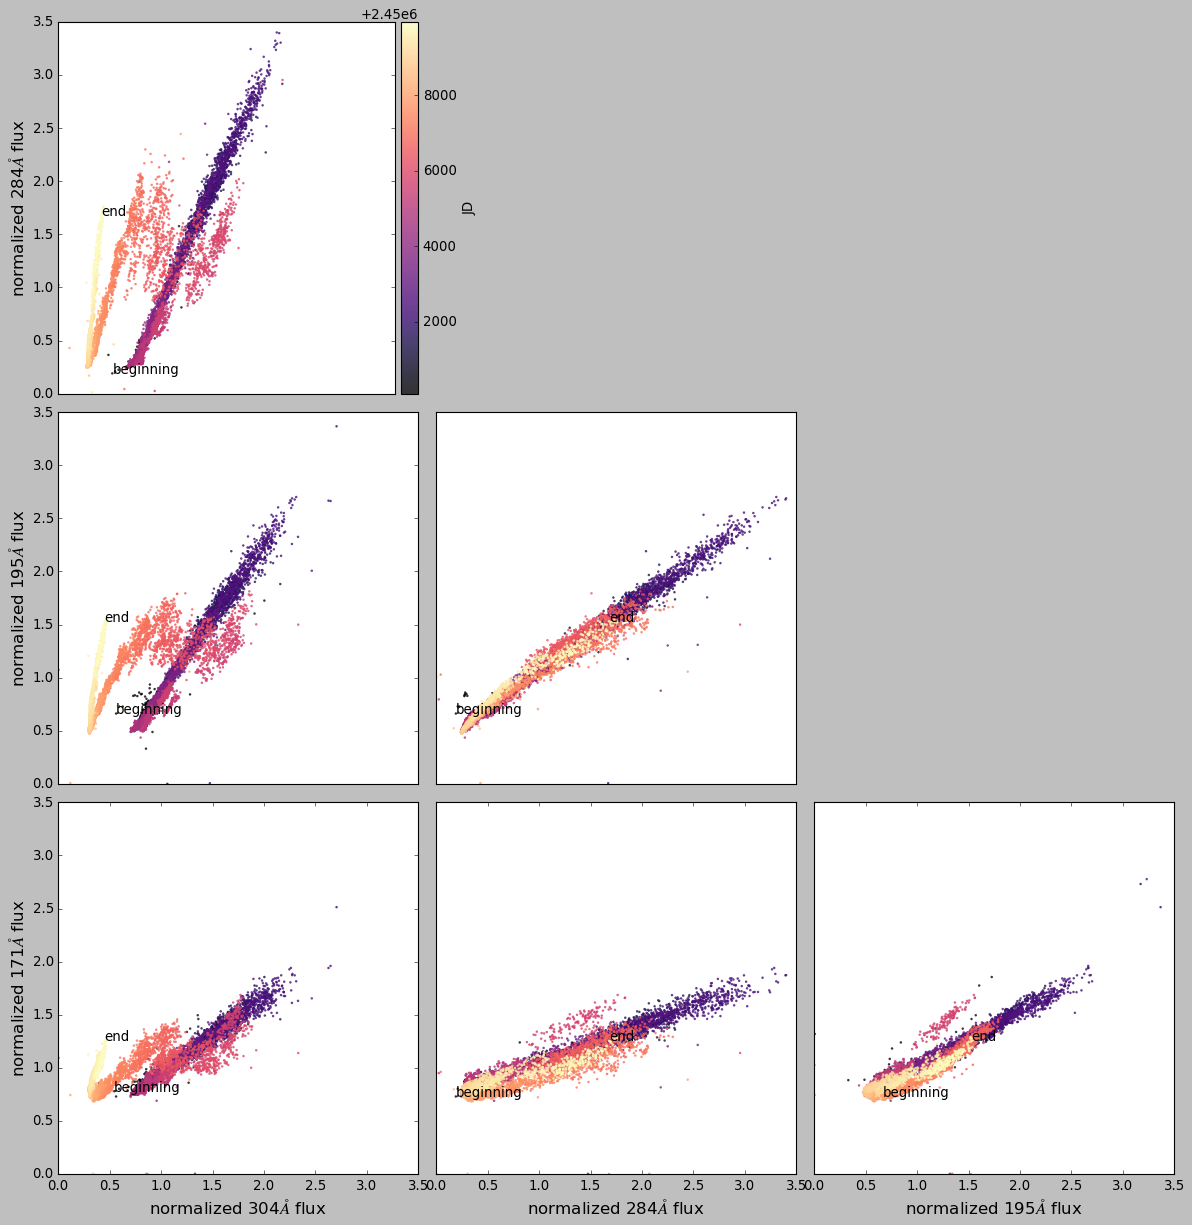

In [151]:
fig, axes = plt.subplots(3,3,figsize=(18,18))

for i in range(1,4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, t304_ind = np.intersect1d(np.round(tEIT,0), np.round(t304,0), return_indices=True)

    c_s = axes[i-1,0].scatter(f304[t304_ind]/np.median(f304[~np.isnan(f304)]), fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]), c=t304[t304_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)
    axes[i-1,0].text(f304[t304_ind][0]/np.median(f304[~np.isnan(f304)]), fEIT[tEIT_ind][0]/np.median(fEIT[~np.isnan(fEIT)]), 'beginning')
    axes[i-1,0].text(f304[t304_ind][-1]/np.median(f304[~np.isnan(f304)]), fEIT[tEIT_ind][-1]/np.median(fEIT[~np.isnan(fEIT)]), 'end')
    
    axes[i-1,0].set_xlim(0,3.5)
    axes[i-1,0].set_ylim(0,3.5)

    if i==1:
        divider = make_axes_locatable(axes[0,0])
        cax = divider.append_axes("right", size="5%", pad="2%")
        fig.add_axes(cax)
        cbar = fig.colorbar(c_s, cax=cax,label="JD")
        #cbar.set_ticks([])


axes[2,0].set_xlabel(r"normalized 304$\AA$ flux",fontsize=15)
axes[0,0].set_ylabel(r"normalized 284$\AA$ flux",fontsize=15)
axes[1,0].set_ylabel(r"normalized 195$\AA$ flux",fontsize=15)
axes[2,0].set_ylabel(r"normalized 171$\AA$ flux",fontsize=15)


for i in range(2,4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, t284_ind = np.intersect1d(np.round(tEIT,0), np.round(t284,0), return_indices=True)

    axes[i-1,1].scatter(f284[t284_ind]/np.median(f284[~np.isnan(f284)]), fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]), c=t284[t284_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)
    axes[i-1,1].text(f284[t284_ind][0]/np.median(f284[~np.isnan(f284)]), fEIT[tEIT_ind][0]/np.median(fEIT[~np.isnan(fEIT)]), 'beginning')
    axes[i-1,1].text(f284[t284_ind][-1]/np.median(f284[~np.isnan(f284)]), fEIT[tEIT_ind][-1]/np.median(fEIT[~np.isnan(fEIT)]), 'end')
    
    axes[i-1,1].set_xlim(0,3.5)
    axes[i-1,1].set_ylim(0,3.5)

axes[2,1].set_xlabel(r"normalized 284$\AA$ flux",fontsize=15)

#axes[1,1].set_ylabel("normalized 195 flux")
#axes[2,1].set_ylabel("normalized 171 flux")


for i in range(3,4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, t195_ind = np.intersect1d(np.round(tEIT,0), np.round(t195,0), return_indices=True)

    axes[i-1,2].scatter(f195[t195_ind]/np.median(f195[~np.isnan(f195)]), fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]), c=t195[t195_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)
    axes[i-1,2].text(f195[t195_ind][0]/np.median(f195[~np.isnan(f195)]), fEIT[tEIT_ind][0]/np.median(fEIT[~np.isnan(fEIT)]),"beginning")
    axes[i-1,2].text(f195[t195_ind][-1]/np.median(f195[~np.isnan(f195)]), fEIT[tEIT_ind][-1]/np.median(fEIT[~np.isnan(fEIT)]),"end")    
    axes[i-1,2].set_xlim(0,3.5)
    axes[i-1,2].set_ylim(0,3.5)

axes[2,2].set_xlabel(r"normalized 195$\AA$ flux",fontsize=15)
#axes[2,2].set_ylabel("normalized 171 flux")


for ax in [axes[0,1],axes[0,2],axes[1,2]]:
    ax.axis("off")

axes[0,0].set_xticks([])
axes[1,0].set_xticks([])
axes[1,1].set_xticks([])

axes[1,1].set_yticks([])
axes[2,1].set_yticks([])
axes[2,2].set_yticks([])
#plt.show()
plt.subplots_adjust(hspace=0.05,wspace=0.05)

plt.savefig("./ratio_EITbands_to_eachother.pdf",bbox_inches="tight")

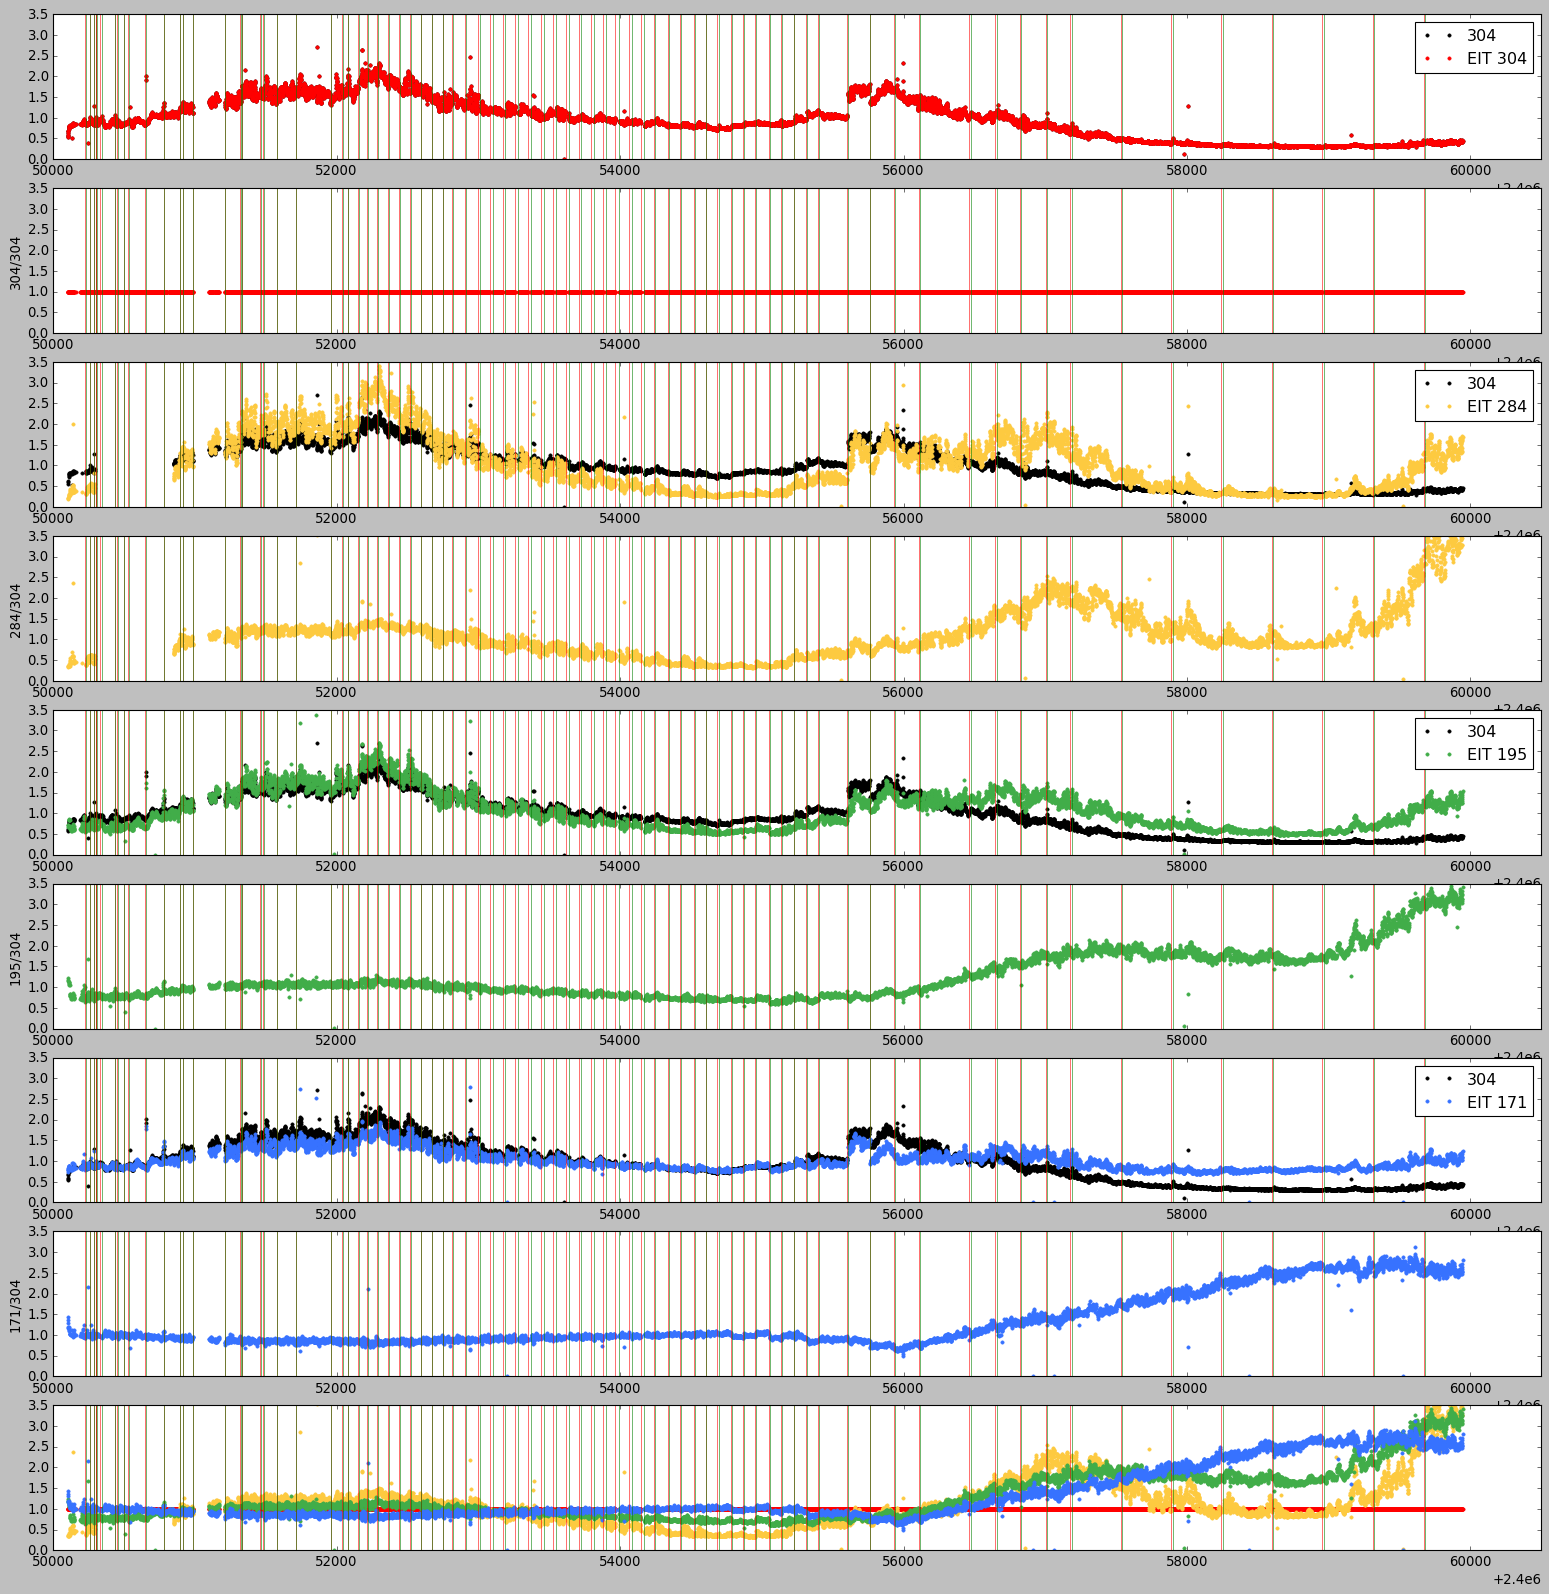

In [117]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, t304_ind = np.intersect1d(np.round(tEIT,0), np.round(t304,0), return_indices=True)
    axes[2*i].plot(t304[t304_ind], f304[t304_ind]/np.median(f304[~np.isnan(f304)]), 'k.',label='304')
    axes[2*i].plot(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]))
    axes[2*i].set_ylim(0.,3.5)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(f304[t304_ind]/np.median(f304[~np.isnan(f304)])),ls='None' ,marker='.',color=cs[i])
    axes[2*i+1].set_ylim(0.,3.5)
    axes[2*i+1].set_ylabel('{0}/304'.format(labels[i]))

    axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(f304[t304_ind]/np.median(f304[~np.isnan(f304)])),marker='.',ls='None',color=cs[i])
    axes[8].set_ylim(0.,3.5)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(80):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    # date of biggest problematic bakeout (11 Feb 2011)
    #ax.axvline(2455602.208, color='y', lw=3)
    #date of big SOHO pointing adjustment (22 Sept 2010)
    #ax.axvline(2455462.239114713, color='y', lw=3)

#plt.show()
plt.savefig("./ratio_EITbands_to_EIT304.pdf",bbox_inches="tight")

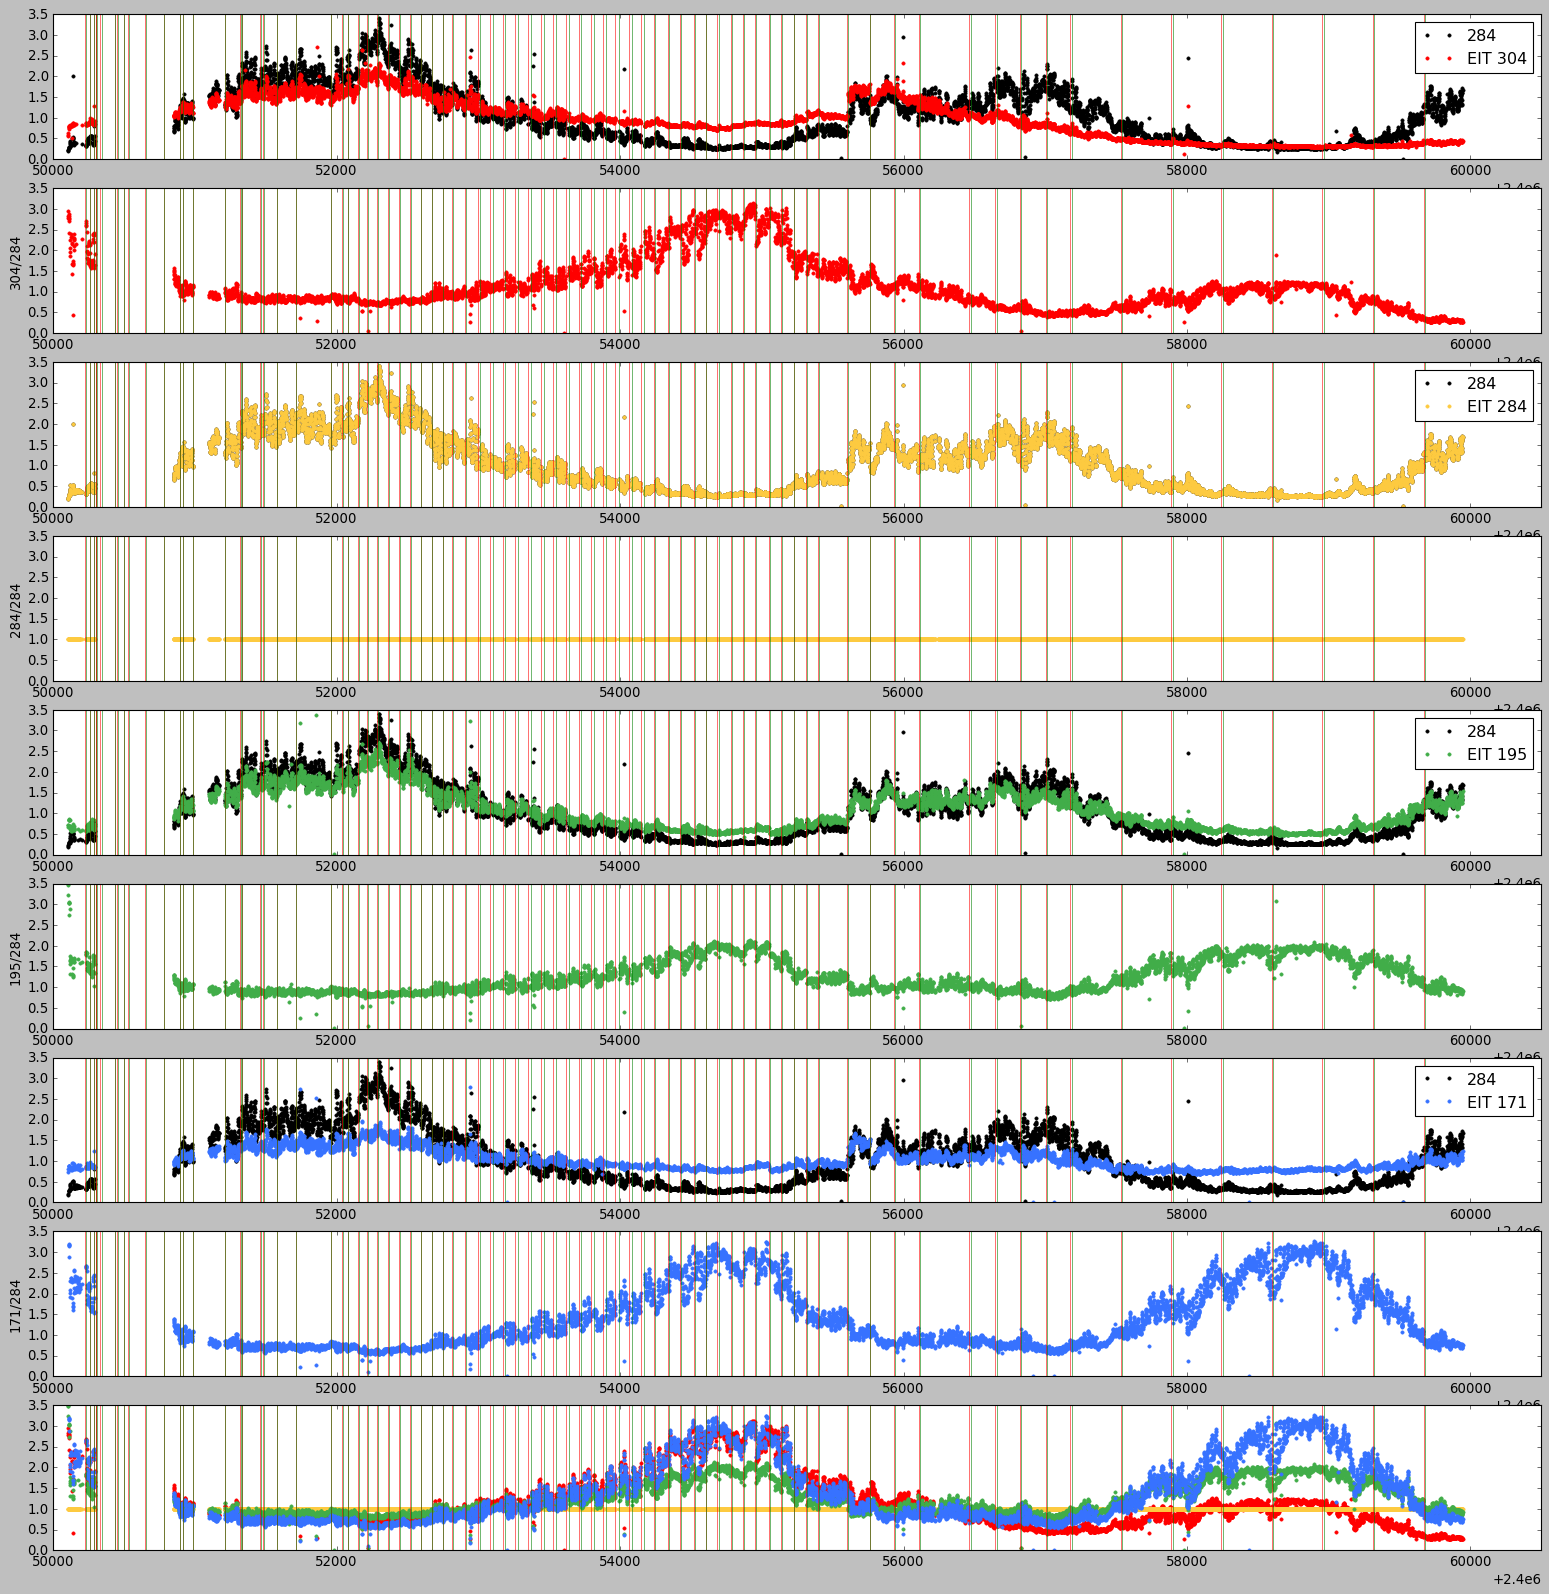

In [120]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, t284_ind = np.intersect1d(np.round(tEIT,0), np.round(t284,0), return_indices=True)
    axes[2*i].plot(t284[t284_ind], f284[t284_ind]/np.median(f284[~np.isnan(f284)]), 'k.',label='284')
    axes[2*i].plot(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]))
    axes[2*i].set_ylim(0.,3.5)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(f284[t284_ind]/np.median(f284[~np.isnan(f284)])),ls='None' ,marker='.',color=cs[i])
    axes[2*i+1].set_ylim(0.,3.5)
    axes[2*i+1].set_ylabel('{0}/284'.format(labels[i]))

    axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(f284[t284_ind]/np.median(f284[~np.isnan(f284)])),marker='.',ls='None',color=cs[i])
    axes[8].set_ylim(0.,3.5)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(80):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    # date of biggest problematic bakeout (11 Feb 2011)
    #ax.axvline(2455602.208, color='y', lw=3)
    #date of big SOHO pointing adjustment (22 Sept 2010)
    #ax.axvline(2455462.239114713, color='y', lw=3)

#plt.show()
plt.savefig("./ratio_EITbands_to_EIT284.pdf",bbox_inches="tight")

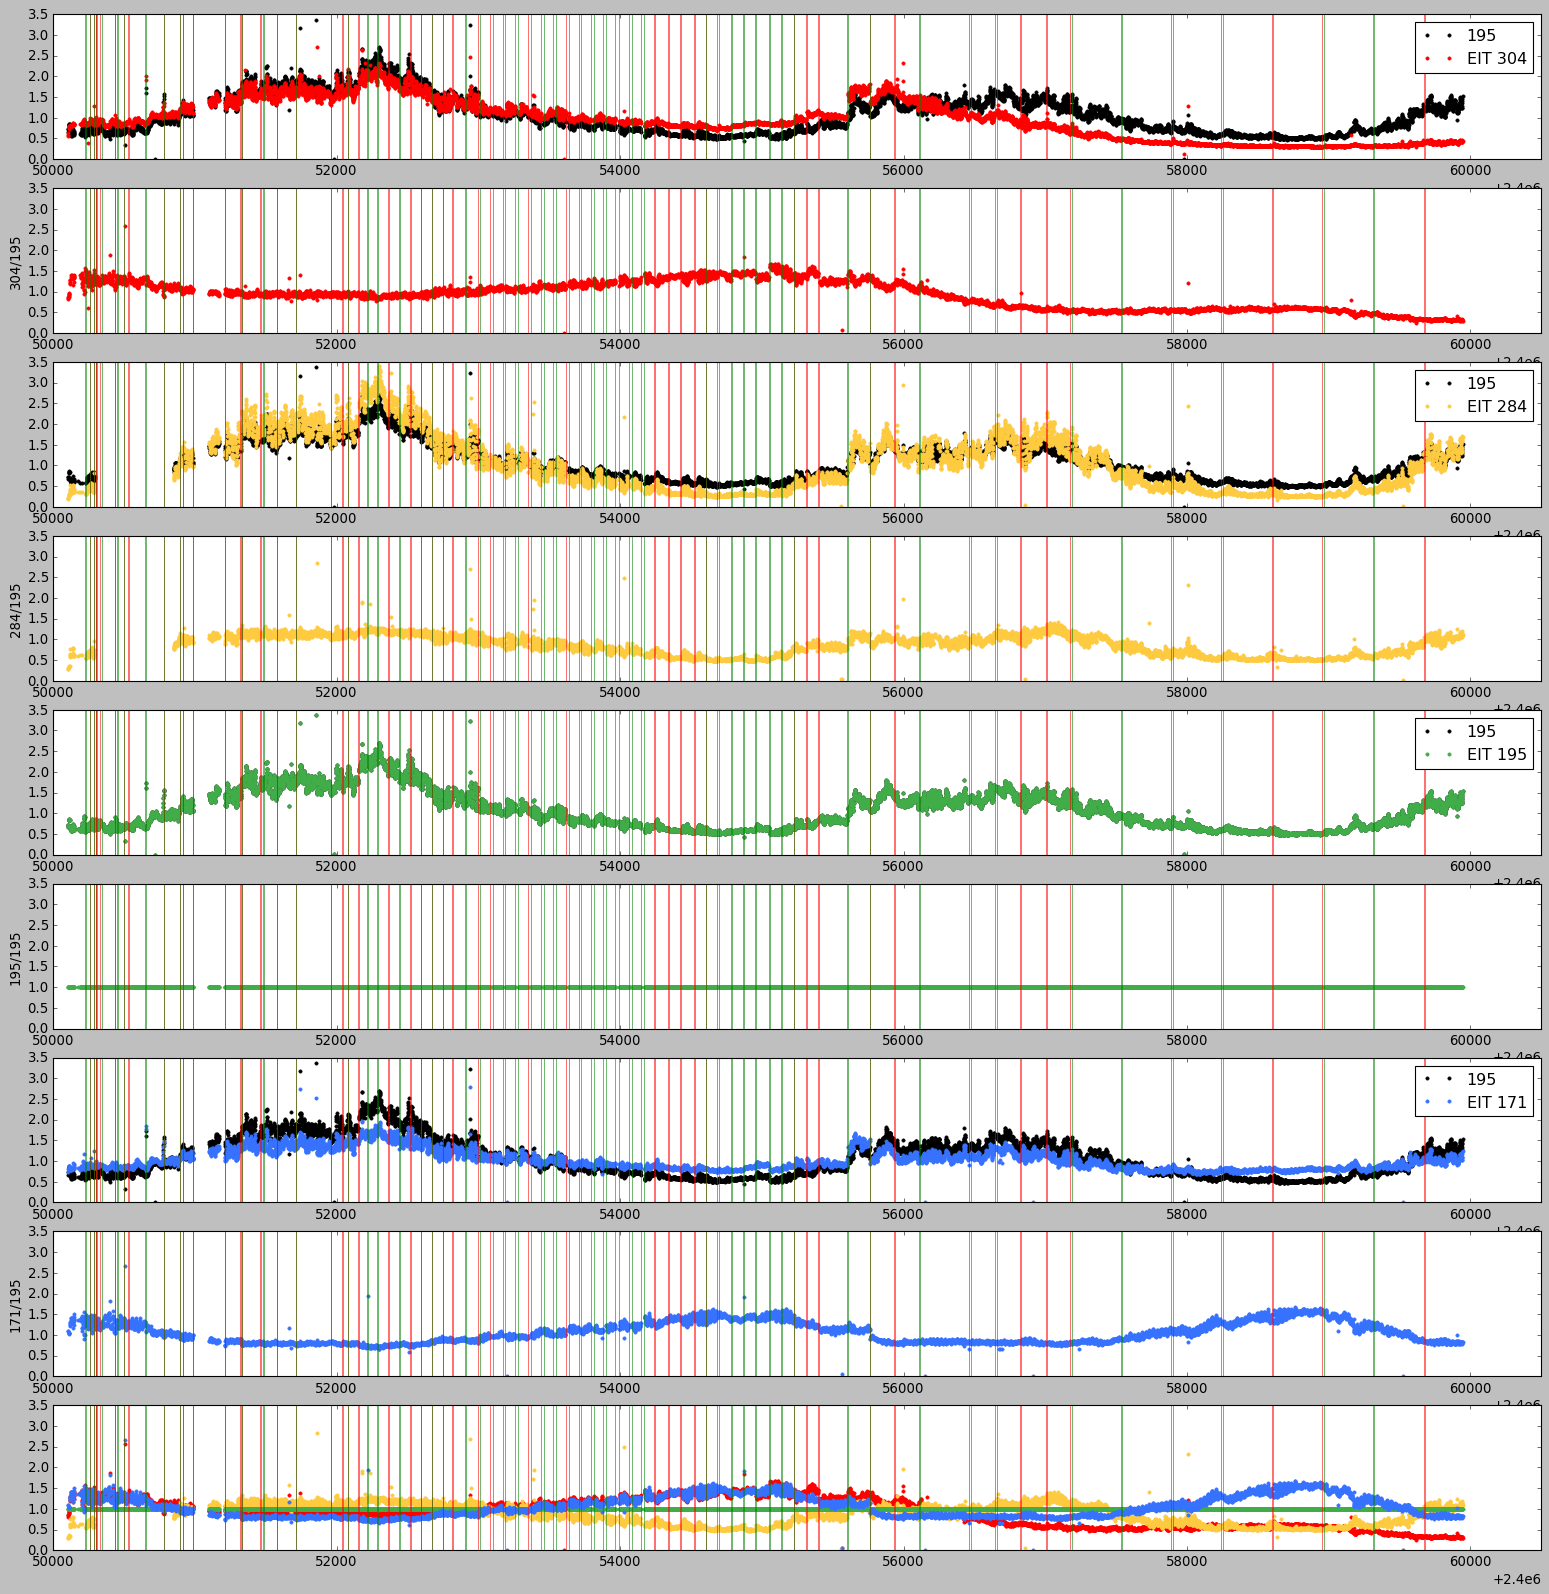

In [121]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, t195_ind = np.intersect1d(np.round(tEIT,0), np.round(t195,0), return_indices=True)
    axes[2*i].plot(t195[t195_ind], f195[t195_ind]/np.median(f195[~np.isnan(f195)]), 'k.',label='195')
    axes[2*i].plot(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]))
    axes[2*i].set_ylim(0.,3.5)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(f195[t195_ind]/np.median(f195[~np.isnan(f195)])),ls='None' ,marker='.',color=cs[i])
    axes[2*i+1].set_ylim(0.,3.5)
    axes[2*i+1].set_ylabel('{0}/195'.format(labels[i]))

    axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(f195[t195_ind]/np.median(f195[~np.isnan(f195)])),marker='.',ls='None',color=cs[i])
    axes[8].set_ylim(0.,3.5)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(80):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    # date of biggest problematic bakeout (11 Feb 2011)
    #ax.axvline(2455602.208, color='y', lw=3)
    #date of big SOHO pointing adjustment (22 Sept 2010)
    #ax.axvline(2455462.239114713, color='y', lw=3)

#plt.show()
plt.savefig("./ratio_EITbands_to_EIT195.pdf",bbox_inches="tight")

# Use the ratio of flux in the EIT 304 band to flux in the SEM narrow band to correct for instrumental effects, inc. bakeouts

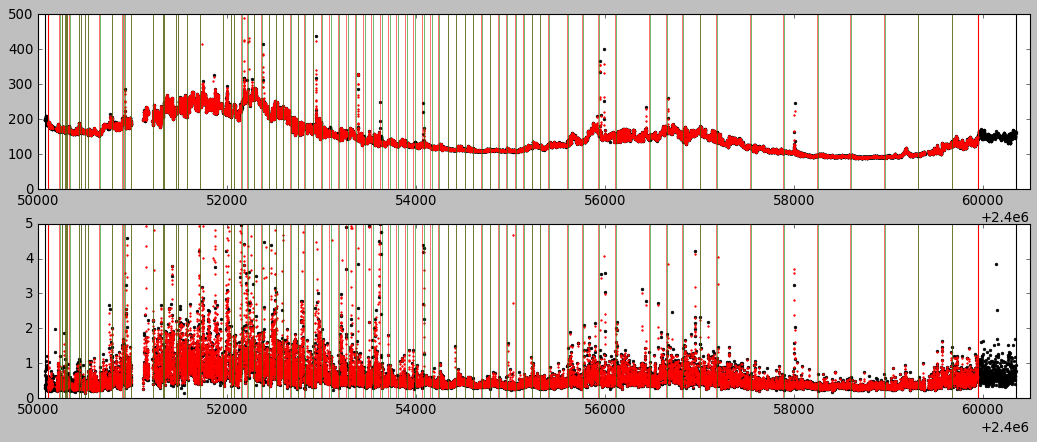

In [12]:
fSEM_interp_304 = np.interp(t304, tSEM, fSEM)
uSEM_interp_304 = np.interp(t304, tSEM, uSEM)

fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].plot(tSEM, fSEM, 'k.',ms=5)
axes[0].plot(t304, fSEM_interp_304, 'r.',ms=3)
axes[0].set_ylim(0,500)

axes[1].plot(tSEM, uSEM, 'k.',ms=5)
axes[1].plot(t304, uSEM_interp_304, 'r.',ms=3)
axes[1].set_ylim(0,5)

for ax in axes:
    ax.set_xlim(2450000,2460500)
    ax.axvline(tSEM[0], color='k')
    ax.axvline(tSEM[-1], color='k')

    ax.axvline(t304[0], color='r')
    ax.axvline(t304[-1], color='r')
    for i in range(80):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)


plt.show()

In [ ]:
med_f304 = np.median(f304[~np.isnan(f304)])
med_fSEM = np.median(fSEM_interp_304[~np.isnan(fSEM_interp_304)])

ratio = (f304/med_f304)/(fSEM_interp_304/med_fSEM)

#analytic uncertainty prop
unc_med_f304 = np.sqrt((np.pi/2) * np.sum(u304**2/len(u304)))
unc_med_fSEM = np.sqrt((np.pi/2) * np.sum(uSEM_interp_304[~np.isnan(uSEM_interp_304)]**2/len(uSEM_interp_304[~np.isnan(uSEM_interp_304)])))

unc_ratio_sq = ((med_fSEM/(fSEM_interp_304 * med_f304))**2 * u304**2) + (((f304*med_fSEM)/med_f304)**2 * (1/fSEM_interp_304**2)**2 * uSEM_interp_304**2) + (((f304*med_fSEM)/fSEM_interp_304)**2 * (1/med_f304**2)**2 * unc_med_f304**2) + ((f304/(fSEM_interp_304 * med_f304))**2 * unc_med_fSEM**2)
unc_ratio = np.sqrt(unc_ratio_sq)

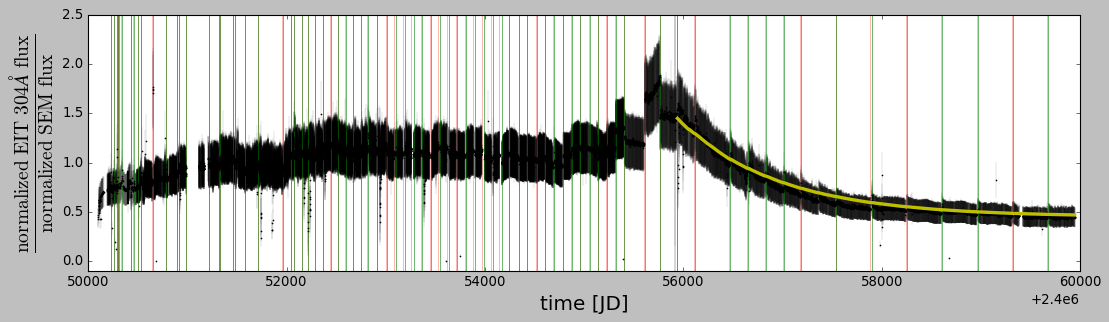

In [136]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.errorbar(t304, ratio, yerr=unc_ratio, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=2)
ax.set_ylim(-0.1,2.5)

for i in range(80):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']
    #for ax in axes:
    ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5,zorder=1,alpha=0.5)
    ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5,zorder=2,alpha=1)

ax.set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=25)
ax.set_xlabel(r"time [JD]", fontsize=18)
#ax.axvline(2455932.375,color='y',lw=3)

xs = np.linspace(0.,4.,7000)
ys = np.exp(-xs)
#ax.plot(1000*xs+2456000, ys+0.45,lw=3,c='y',zorder=10)


ax.plot(t304[t304 >= 2455938], ys[:6910]+0.45, lw=3,c='y',zorder=10)

"""testRemoveExp = np.ones_like(t304)
testRemoveExp[t304 >= 2455938] = ys[:6910] + 0.45

axes[1].errorbar(t304, ratio/testRemoveExp, yerr=unc_ratio, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=2)
axes[1].set_ylim(-0.1,2.5)
"""
"""
for ax in axes:
    ax.set_xlim(2452000,2453000)
    ax.axvline(2452941,color='m',lw=1)
    ax.axvline(2452177,color='m',lw=1)
    ax.axvline(2452237,color='m',lw=1)
    ax.axvline(2452384,color='m',lw=1)
"""
#plt.show()
plt.savefig("./ratio_EIT304_to_SEM.pdf",bbox_inches="tight")

In [14]:
def correctByRatio(t, f, u, t_ratio, ratio, unc_ratio, plot=True):
    norm = np.median(f[~np.isnan(f)])
    ratio_interp = np.interp(t, t_ratio, ratio)
    unc_ratio_interp = np.interp(t, t_ratio, unc_ratio)

    if plot is True:
        fig, ax = plt.subplots(1,1,figsize=(16,4))
        ax.plot(t, f/norm, 'r.')
        ax.plot(t, (f/ratio_interp)/norm, 'k.')
        #ax.set_xlim(2454000, 2456000)
        ax.set_ylim(0.,5.)
        plt.show()

    u_new_sq = (u**2/ratio_interp**2) + (unc_ratio_interp**2/ratio_interp**4)
    u_new = np.sqrt(u_new_sq)
    
    return norm, f/ratio_interp, u_new

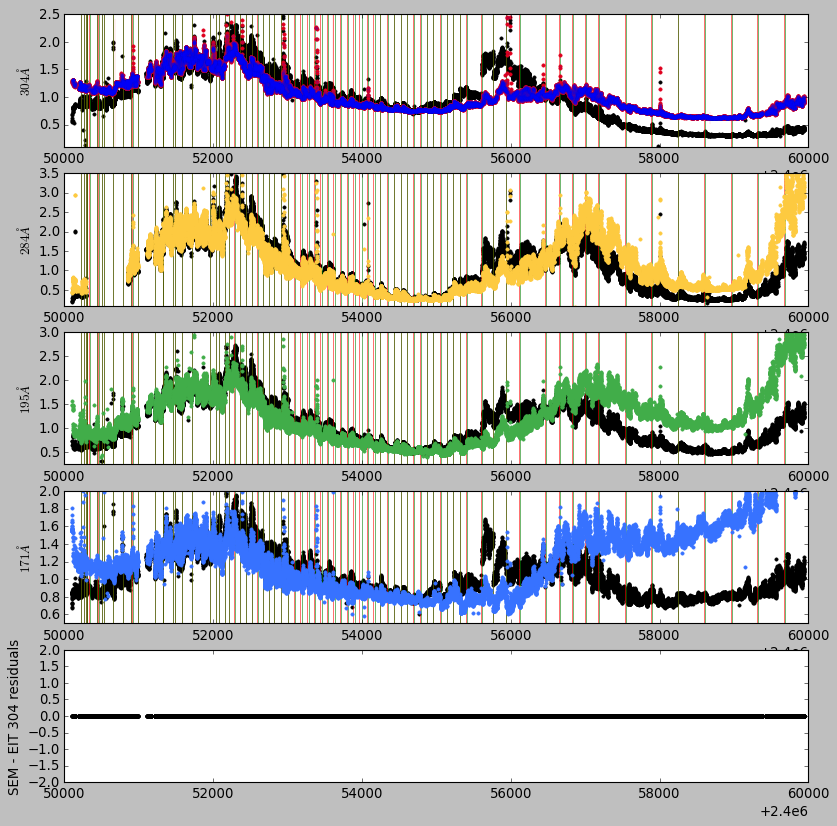

In [21]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
labels =['304','284','195','171']

fig, axes = plt.subplots(5,1,figsize=(12,12))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_] 
    uEIT = us[wmask_]
    norm, fcorrect, ucorrect = correctByRatio(t=tEIT, f=fEIT, u=uEIT, t_ratio=t304, ratio=ratio, unc_ratio=unc_ratio, plot=False)

    #axes[i].plot(tEIT, fEIT/norm, 'k.')
    #axes[i].plot(tEIT, fcorrect/norm, marker='.', color=cs[i],ls='None')

    axes[i].errorbar(tEIT, fEIT/norm, uEIT/norm, color='k', marker='.',ls='None',elinewidth=0.1,capsize=0,zorder=1)
    axes[i].errorbar(tEIT, fcorrect/norm, ucorrect/norm, color=cs[i], marker='.',ls='None',elinewidth=0.1,capsize=0,zorder=2)
    axes[i].set_ylabel(r"${0}\AA$".format(labels[i]))
    #axes[i].set_xlim(2450000, 2460500)
    #axes[i].set_xlim(2455000, 2457000)
    axes[i].set_ylim(0.,4.)

    if i==0:
        axes[4].plot(t304, fSEM_interp_304/np.median(fSEM_interp_304[~np.isnan(fSEM_interp_304)]) - fcorrect/norm, 'k.')

    for j in range(80):
        bakeoutStartDate = heaterOn[j]['jd']
        bakeoutEndDate = heaterOff[j]['jd']

        axes[i].axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        axes[i].axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)


    #axes[i].plot(tSORCE, fSORCE/np.median(fSORCE[~np.isnan(fSORCE)]), 'c-',zorder=4)

#plot SEM
axes[0].errorbar(t304, fSEM_interp_304/np.median(fSEM_interp_304[~np.isnan(fSEM_interp_304)]), uSEM_interp_304/np.median(fSEM_interp_304[~np.isnan(fSEM_interp_304)]), color='b', marker='.',ls='None',elinewidth=0.1,capsize=0,alpha=0.1,zorder=3)
#axes[4].set_xlim(2455000, 2457000)
axes[4].set_ylim(-2,2)
axes[4].set_ylabel("SEM - EIT 304 residuals")

axes[0].set_ylim(0.1,2.5)
axes[1].set_ylim(0.1,3.5)
axes[2].set_ylim(0.25,3.)
axes[3].set_ylim(0.5,2.)

plt.show()

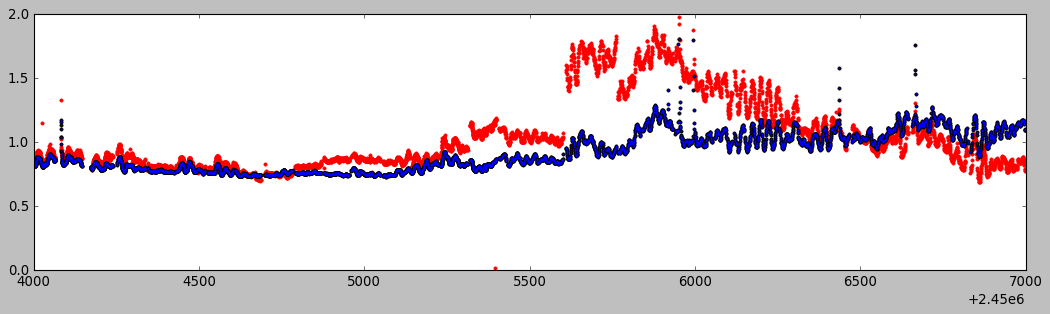

In [22]:
norm = np.median(f304[~np.isnan(f304)])
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(t304, f304/norm, 'r.')
ax.plot(t304, (f304/ratio)/norm, 'k.')
ax.plot(t304, fSEM_interp_304/np.median(fSEM_interp_304[~np.isnan(fSEM_interp_304)]), 'b.',ms=2)
ax.set_xlim(2454000, 2457000)
#ax.set_ylim(0.,1.e8)
ax.set_ylim(0,2)
plt.show()

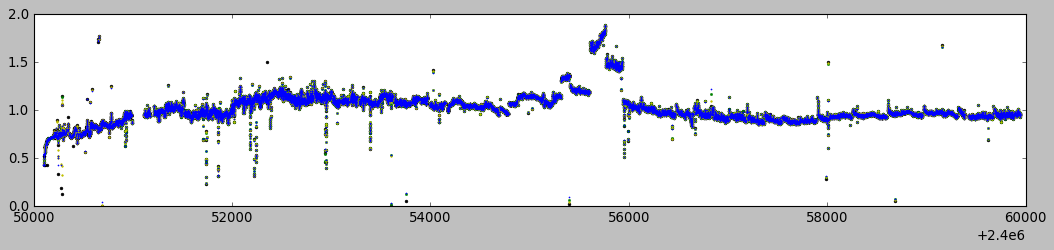

In [162]:
ratio_interp_284 = np.interp(t284, t304, ratio/testRemoveExp)
ratio_interp_195 = np.interp(t195, t304, ratio/testRemoveExp)
ratio_interp_171 = np.interp(t171, t304, ratio/testRemoveExp)
fig, ax = plt.subplots(1,1,figsize=(16,3))
ax.plot(t304, ratio/testRemoveExp, 'k.',ms=5)
ax.plot(t284, ratio_interp_284, 'g.',ms=4)
ax.plot(t195, ratio_interp_195, 'y.',ms=3)
ax.plot(t171, ratio_interp_171, 'b.',ms=2)
ax.set_ylim(0.,2.)
plt.show()

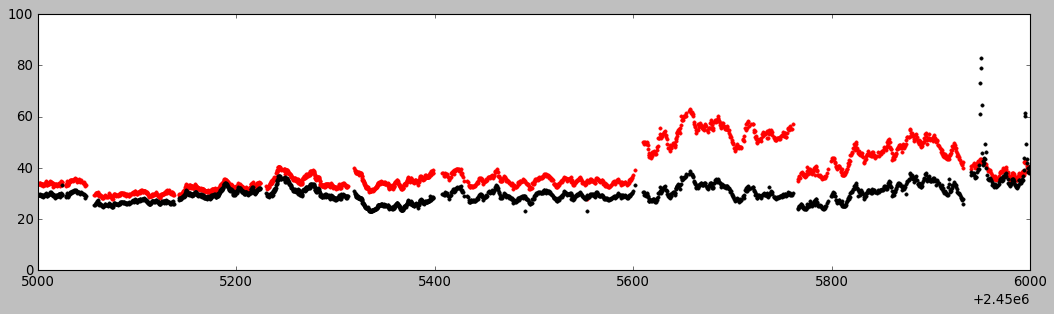

In [163]:
norm = np.median(t171[~np.isnan(t171)])
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(t171, f171/norm, 'r.')
ax.plot(t171, (f171/ratio_interp_171)/norm, 'k.')
ax.set_xlim(2455000, 2456000)
#ax.set_ylim(0.,1.e8)
ax.set_ylim(0,100)
plt.show()